# Elasticsearch Synonym Filters
The following files explains the approach used to build up an Elasticsearch synonym filter file from the SOAM data structure (see file 0.1.1 regarding the SOAM data structure)

https://www.elastic.co/guide/en/elasticsearch/reference/2.4/analysis-synonym-tokenfilter.html

#### Very Base Requirements 
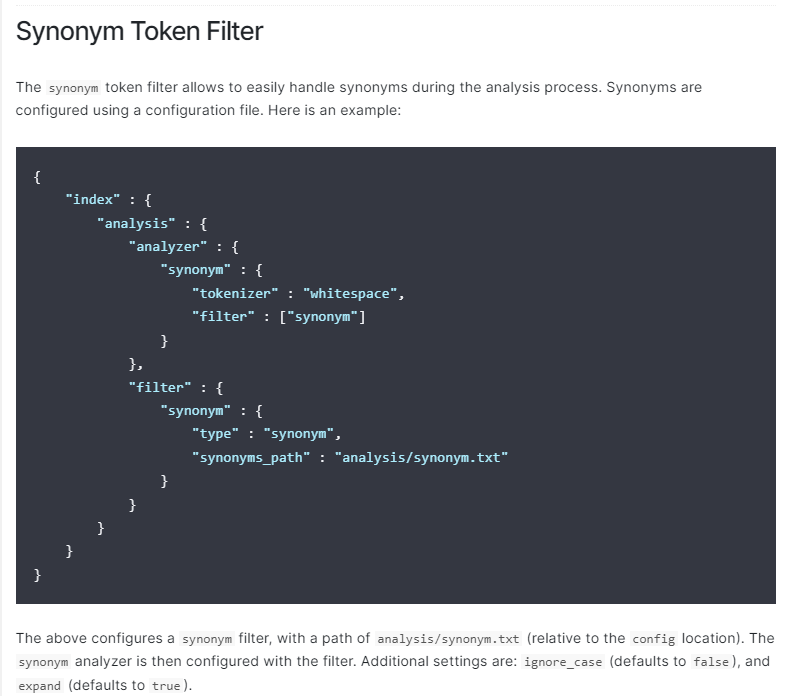

... So I will need two files
* config 
* synonym.txt

### Two Synonym Formats are Supported
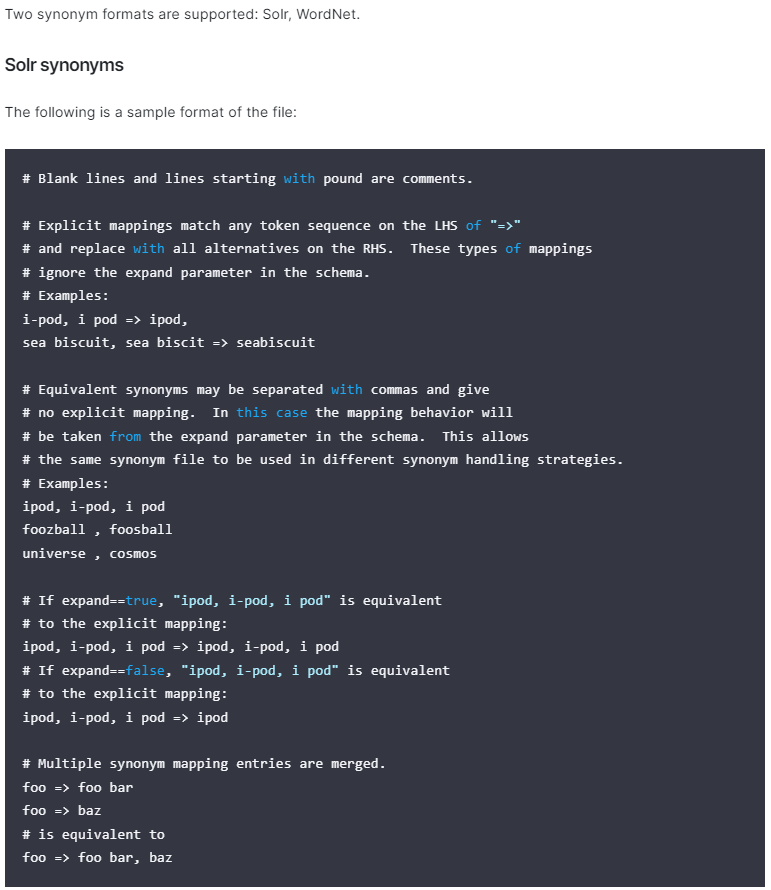
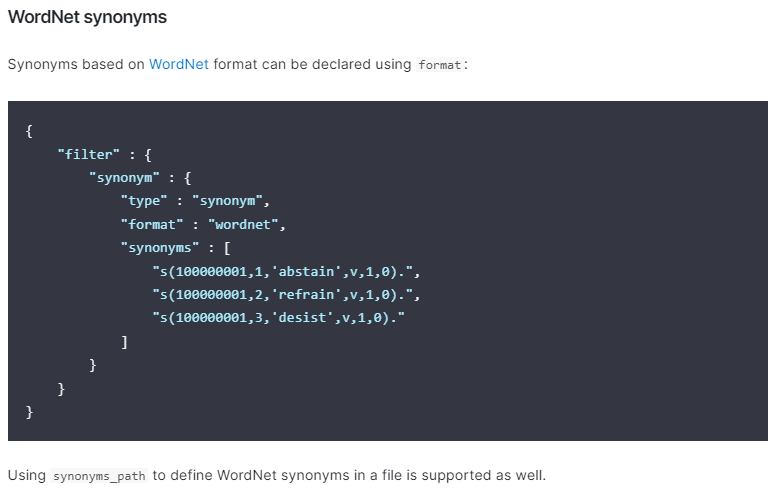

I will be using Solr synonyms in the Equivalent synonym format separated with commas (as all our synonyms we are concerned with as celestial / space objects (confusing nouns that can be represented by multi-word common names and IDs)

#### Additional article on using synonym filters 
https://medium.com/version-1/synonyms-in-elasticsearch-c527280ba8a5
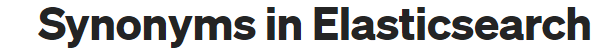
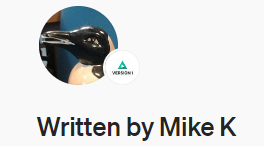

w/ comments by me (Zach Jacobson)

<br>

#### Consider adding fuzziness and multi-field searches

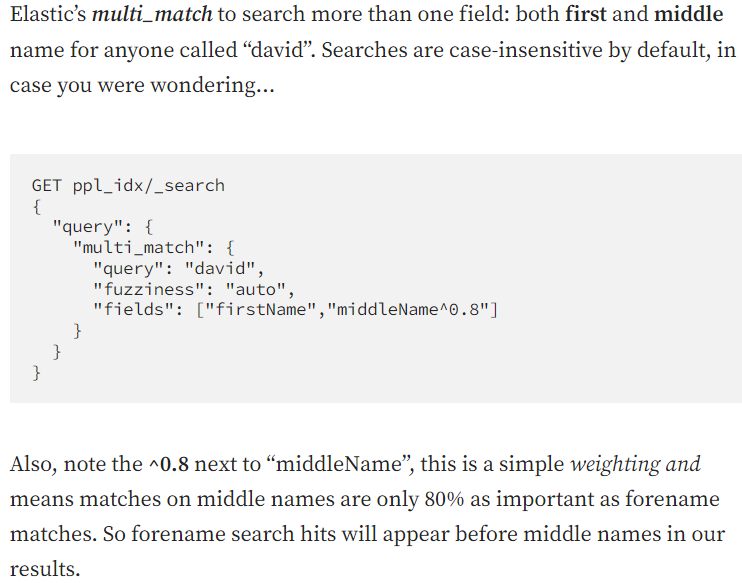

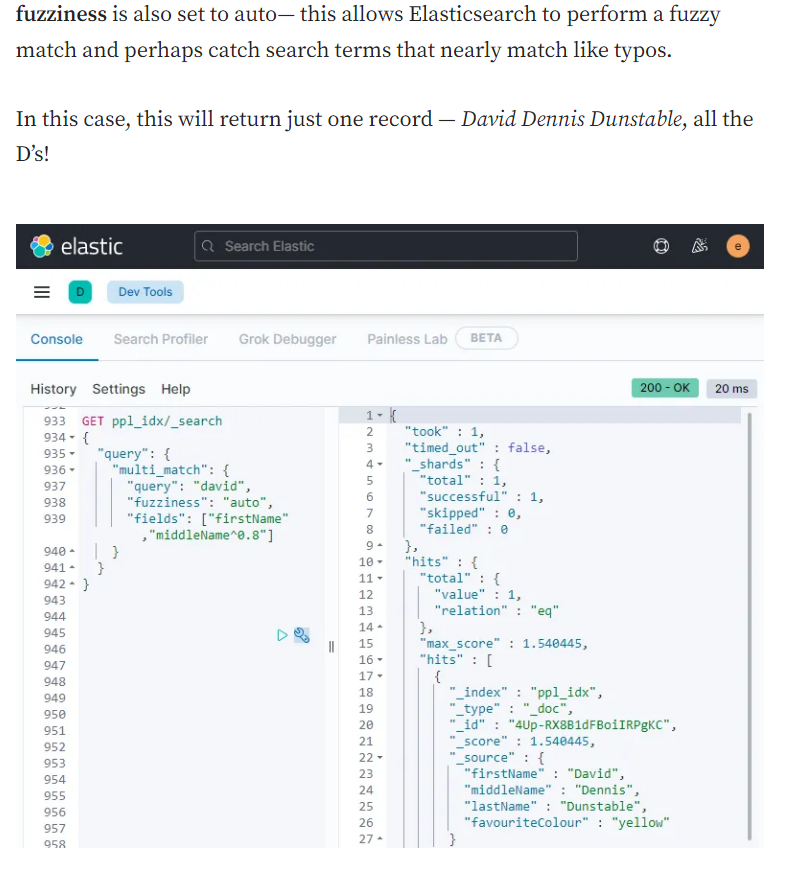

<br>

#### Additional comments on how to implement synonyms within config file (must be done within each Elastic index node?)... this assumes that our `synonym.txt` file is now `names.csv`...

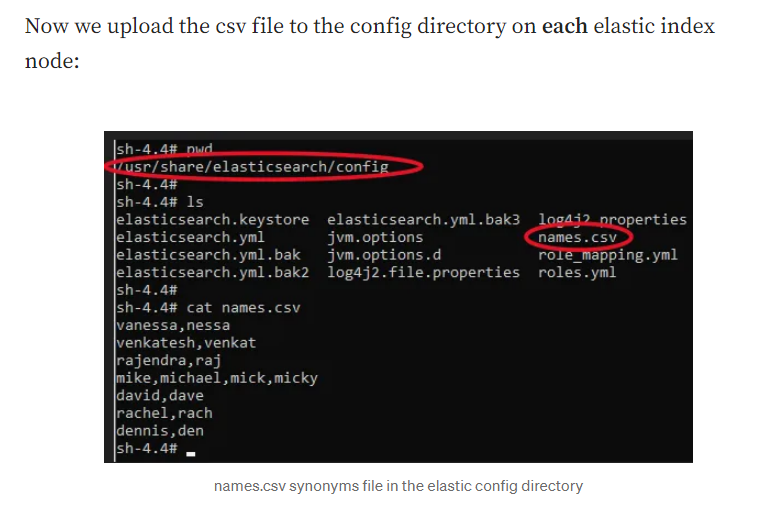

<br>

#### Consider the Analyser when implementing synonyms

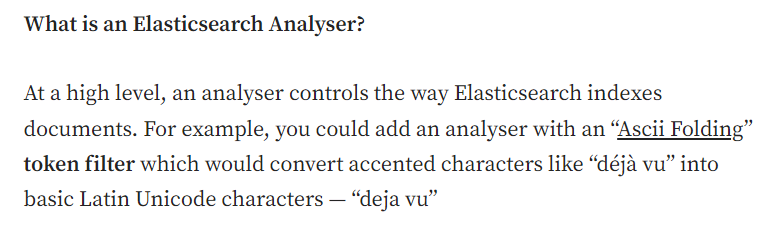

#### Additional details for analyzers
https://www.elastic.co/blog/found-text-analysis-part-1

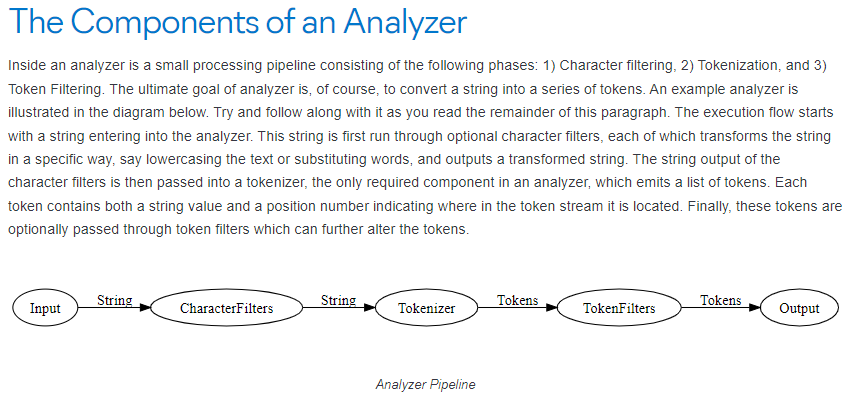

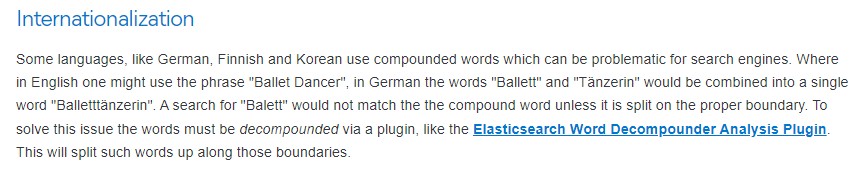
https://github.com/jprante/elasticsearch-analysis-decompound

### Custom Analyser (`names_analyser`) w/ Custom Synonym (`names.csv`) File

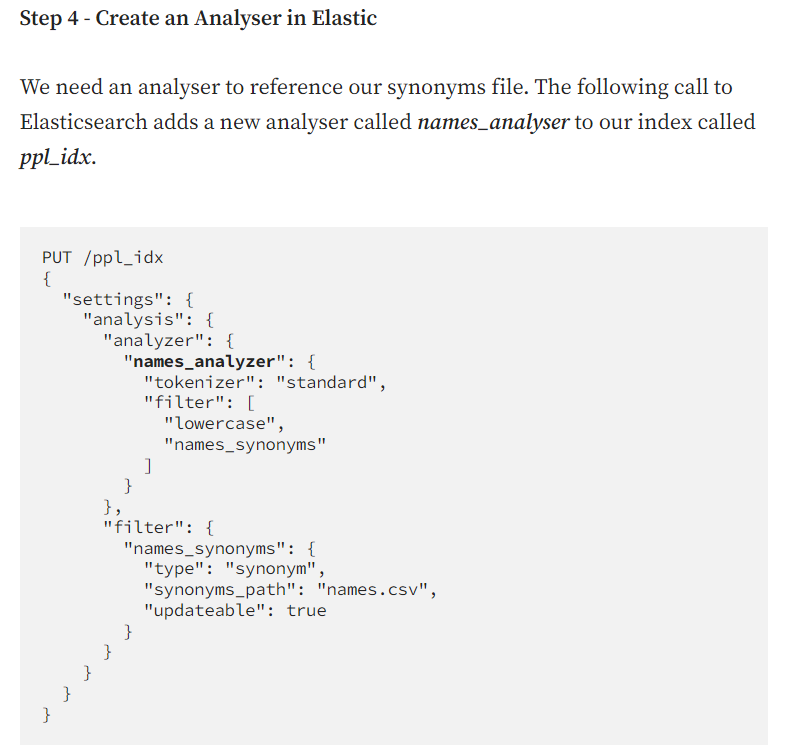

#### Other considerations 

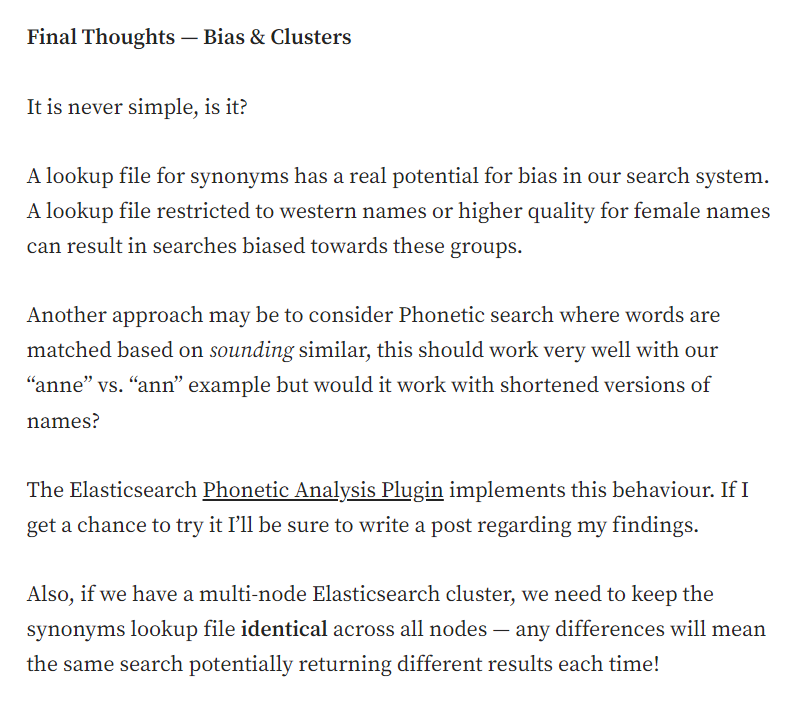

https://www.elastic.co/guide/en/elasticsearch/plugins/2.4/analysis-phonetic.html
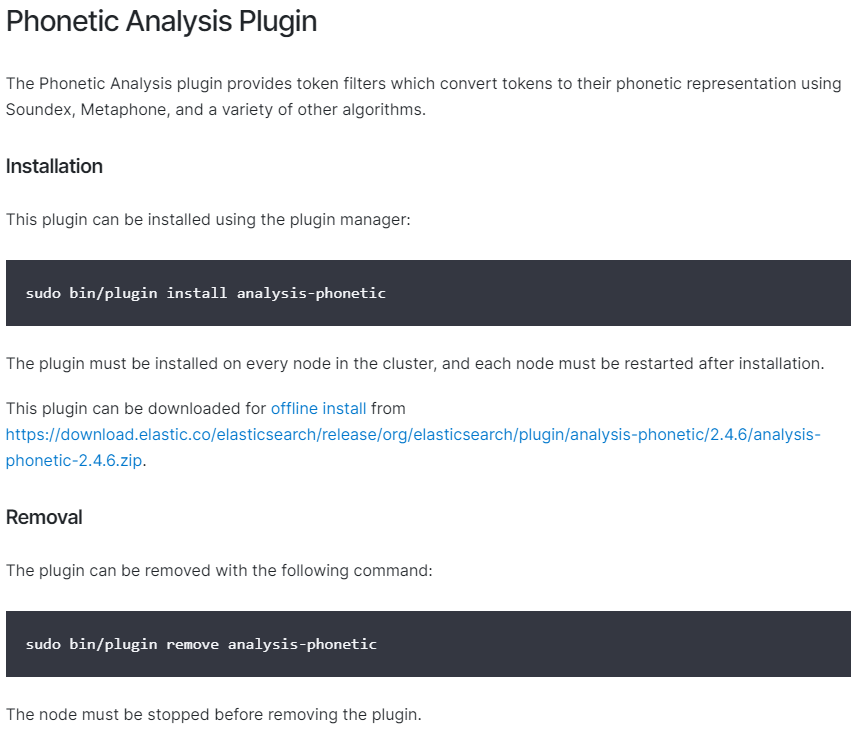

# Another Question
Is there a way to match "m-31" with "m 31" and "M31"?

Firstly, in regards to case sensitivity, recall Mike article above... be sure to add `lowercase` to the analyzer filter you make...

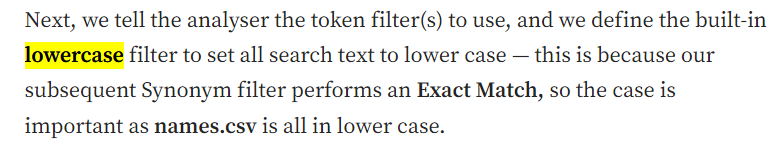

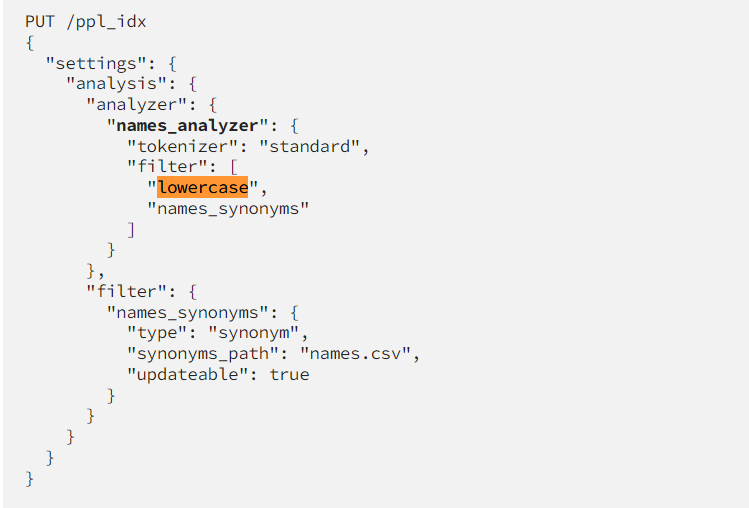

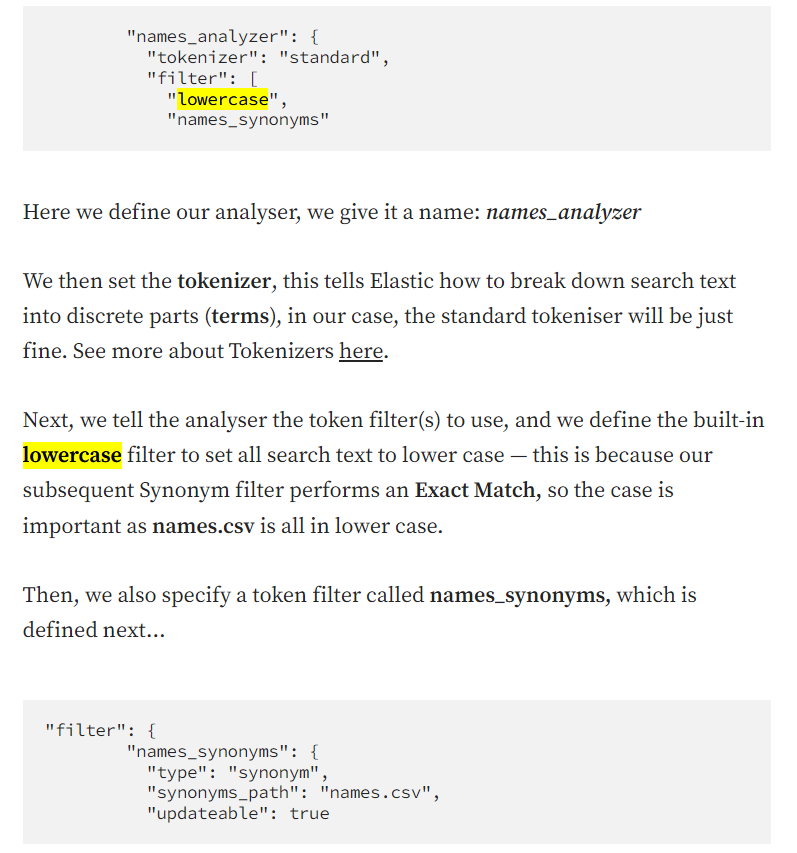

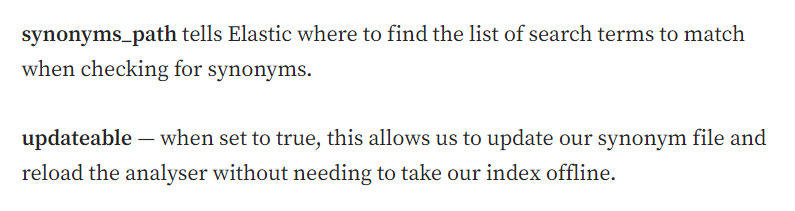

Lastly, for the spacing, hyphens, and other deliminating patterns; Elasticsearch has us covered here as well!

https://www.elastic.co/guide/en/elasticsearch/reference/2.4/analysis-word-delimiter-tokenfilter.html

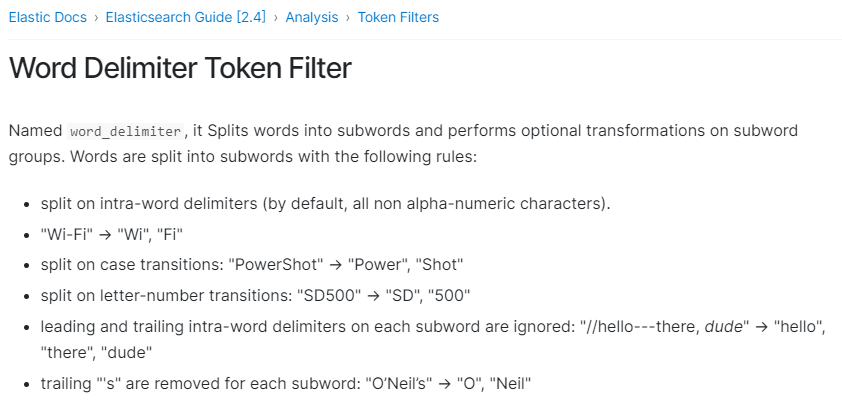

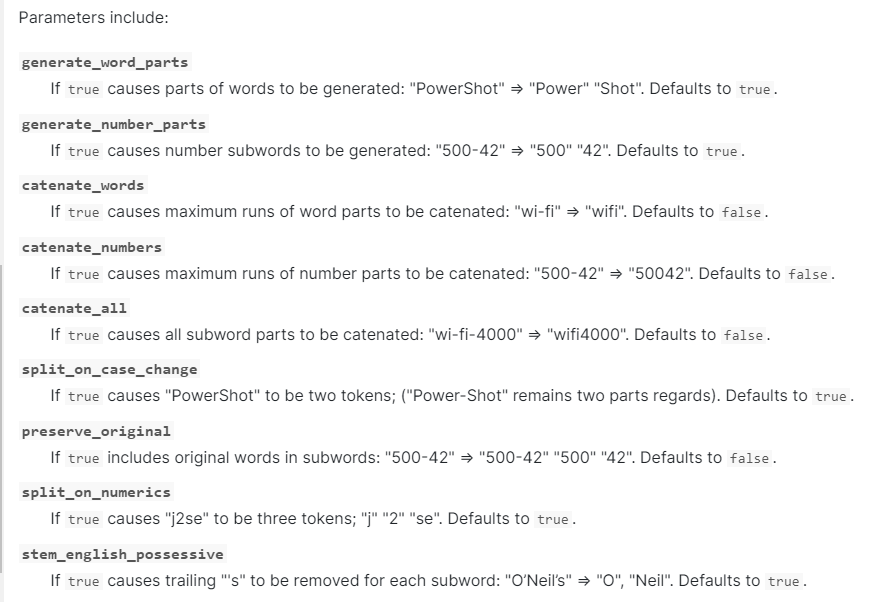

#### Example of including a word deliminator token filter
https://stackoverflow.com/questions/42484892/elasticsearch-and-word-delimiter-token-filter
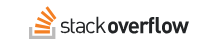
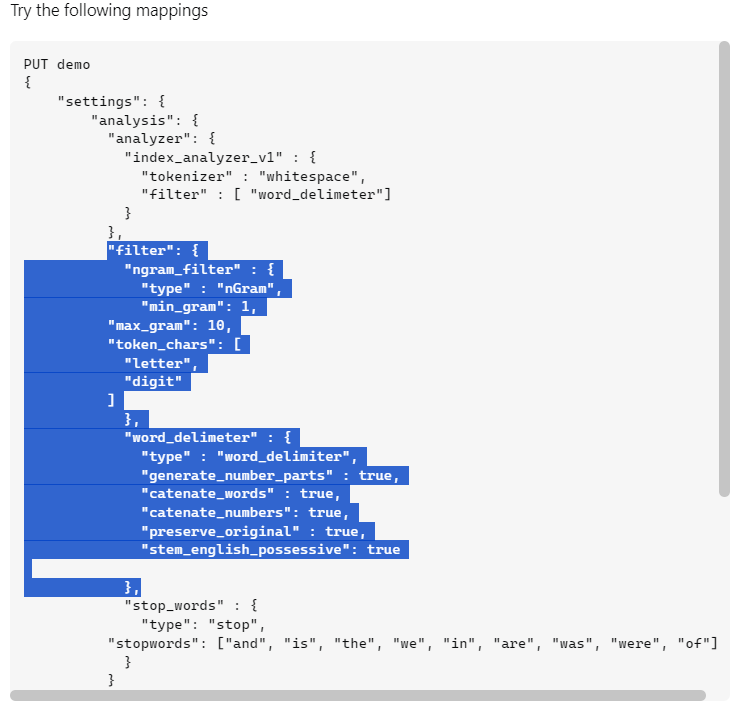

# AstroBin uses Django with Haystack

https://django-haystack.readthedocs.io/en/master/tutorial.html

#### Can we even set configurations of Elastisearch with Django / Haystack?

https://stackoverflow.com/questions/29254643/add-elasticsearch-synonyms-with-django-haystack
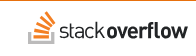
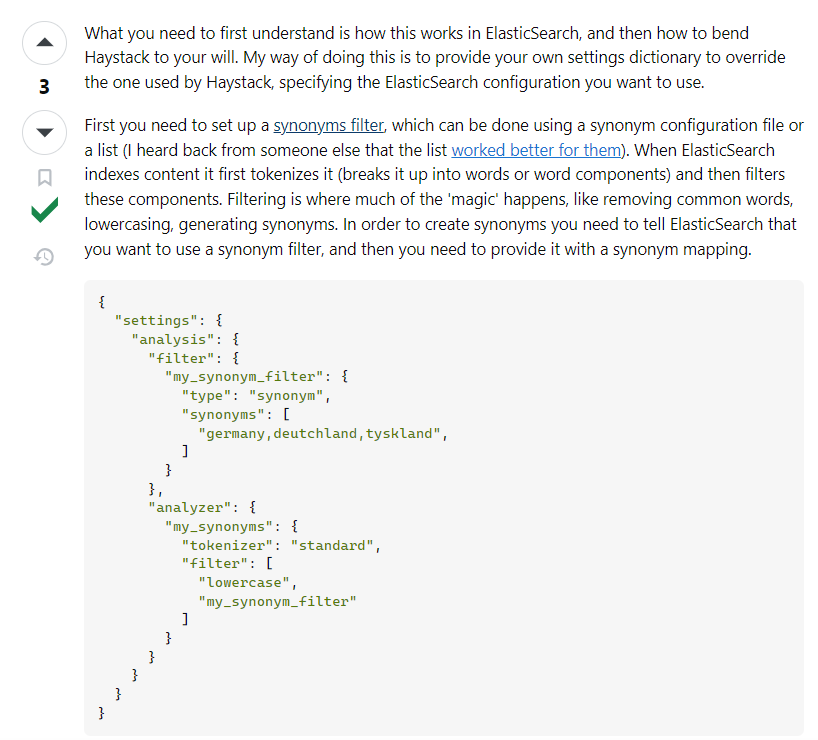

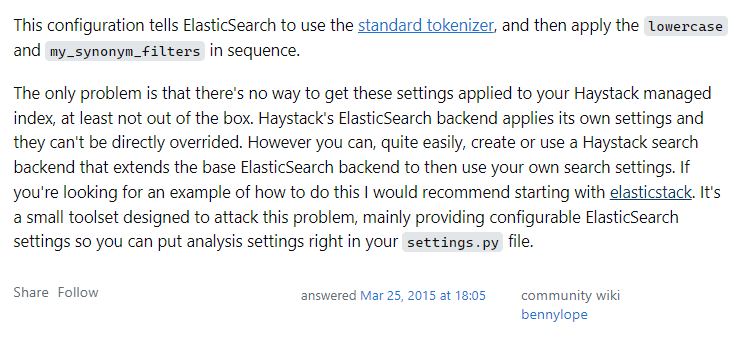

https://github.com/bennylope/elasticstack/
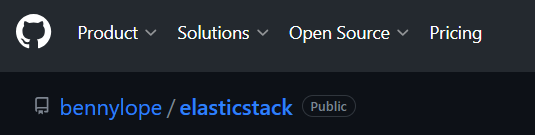

# START BUILDING!

### What are some details we need to consider:
* The filter must allow (for example) the following search results to return the same results
    * "m 31"
    * "m31"
    * "M-31"
    * "Andromeda Galaxy"
    * "NGC 224"
    * ... etc ...

* So that means we need to have the following in place:
    * case standardization (`"filter":["lowercase"]`)
    * delimination standardization (remove hyphens and recognize all alpha-numeric words the same way, even if there are spaces, and find a way tokenize common names which will typically be comprised of multiple words seperated with a space...)
        * One approach to delimination standardization would be to leverage the word deliminator features in Elastisearch (like `split_on_numerics`)
        * A second approach would be to expand the selected aliases into the "i pod" example... (the equivelent listing of `i-pod, i pod, ipod` in a `synonym.txt` file... I would opt for this approach... but probably should double check the configuration of AstroBin Elasticsearch.

* Additionally we will need to trim out the pertinent objects (from the title data


In [1]:
import pandas as pd

#Homemade methods and classes (includes astropy tools, not written by me)
import classes_and_methods.soam_class as soam
from classes_and_methods.simbad_alias_search import online_alias_search

In [2]:
#df to hold all the title data (to be used to help focus our synonym filter file)
df = pd.read_csv("data/astrobin_titles_to_subject_types.csv") #the main starting data frame
df

,title,subject_type,solar_system_main_subject
0,Pillars of Creation (M16 - Eagle Nebula) in SH...,NaN,NaN
1,Zigarren Galaxie,DEEP_SKY,NaN
2,M 16,DEEP_SKY,NaN
3,M71 - Ammasso globulare - Costellazione della ...,DEEP_SKY,NaN
4,NGC2903 A bright Galaxy in Leo,DEEP_SKY,NaN
...,...,...,...
600263,"IC 1318, take 2",DEEP_SKY,NaN
600264,M33,DEEP_SKY,NaN
600265,M109 - 100% crop,DEEP_SKY,NaN
600266,NGC663 and NGC457 in Cassiopeia,DEEP_SKY,NaN


In [3]:
#Now we will want a Space Object Alias Map
cleaned_soam = soam.Soam()
cleaned_soam.import_soam(file_name="soam_cleaned_bulk_export")
print(cleaned_soam)

#... to get all names listed in the SOAM use...
# cleaned_soam.all_names()

SOAM Started ---------------- 
SOAM Cleaning Method Test -- 
original test string: "   #][!,@ ^&*NGc224-.99+9abc. ...   "
cleaned test string: "ngc 224 99 9 abc"
25642 names / aliases mapped across 4264 objects.


In [4]:
#quick clean the title data
df['cleaned_title'] = df['title'].astype(str).apply(soam.provided_cleaning_method)

In [5]:
#collect all names from the title data (would also work with uncleaned titles as well...)
df['all_names_and_ids'] = df['cleaned_title'].apply(cleaned_soam.find_all_names)

In [6]:
#expand all name lists into individual rows then put them all into a set (removing duplicates)
all_title_names = set(df['all_names_and_ids'].explode())
all_title_names = {str(name) for name in all_title_names} #then cast all items in the set as a str

In [7]:
#ignore all len(name) < 2
#ignore all len(name) <= 3, unless...
#  ... name[0] in [m, c, i, n, s]
#ignore all name[0].isdigit() 
#

all_title_names = {
    name
    for name in all_title_names
    if len(name) >= 2 and 
    (len(name) > 3 or name[0] in ['m', 'c', 'i', 'n', 's']) and 
    not name[0].isdigit()
}

In [8]:
#we should probably avoid "c " containing ids that are also found in the GEAR category
s = "c "
gear_c_ids = set(df[(df['subject_type'] == 'GEAR') & (df['cleaned_title'].str.contains(s))]['all_names_and_ids'].explode())
gear_c_ids = {str(name) for name in gear_c_ids}
gear_c_ids = {ignore_id for ignore_id in gear_c_ids if ignore_id[0] == 'c'}

#removing title names that match the gear names
all_title_names = {name for name in all_title_names if name not in gear_c_ids}

#... and do the same for 'eyes'
all_title_names = {name for name in all_title_names if name != 'eyes'}

In [9]:
# additional removals should include
# ... ignoring the "mm "
all_title_names = {name for name in all_title_names if 'mm ' not in name}
#... others ?

In [10]:
#using the cleaned_soam and all_title_names identified, make a simple_soam

#first, trim out all names from the soam that were not found in the title data
soam_names = {key: value for key, value in cleaned_soam.all_names().items() if key in all_title_names} 

#now there are two choices:

#Choice 1) associate only the names found in title data which share a cleaned_soam alias key
aliases = {}
for key,value in soam_names.items():
    #print(str(key) +" : "+str(value))
    if value in aliases:
        aliases[value].add(key)
    else:
        aliases[value] = {key}
astrobin_associations = [list(alias_set) for alias_set in aliases.values()] #if len(alias_set) > 1]

#Choice 2) associate all names found in title data which share a cleaned_soam alias key 
#             AND build some rules to also pull certain aliases from the corresponding alias set
# ... NOT IMPLEMENTING CHOICE 2, Choice 1 is enough...

In [11]:
# Now again, we have more choices

#Choice 1) leave astrobin_associations as is and build a new astrobin_soam
# ... NOT IMPLEMENTING CHOICE 1, we can do more...

#Choice 2) modify the astrobin_associations to account for variations of id conventions
#      ... Example: 
#          'm 1', 'messier 1', 'm1', 'm-1'
#          'ngc 1952',
#          'sh 2 244', 'sharpless 244'
# ... NOT IMPLEMENTING CHOICE 2, 
#    the hyphen and spacing variations could be handeled by a word delimination token filter...
#    
#Choice 3) modify the astrobin_associations to only simply expand catelog IDs into their written names
#      ... Example: 
#          'm 1', 'messier 1'
#          'ngc 1952',
#          'sh 2 244', 'sharpless 244'
# ... So we could simply make some rules:
# 'sh 2 ' => sharpless
# 'm ' => messier
# 'c ' => caldwell

#PROCEEDING WITH Choice 3)
import re
def replace_substrings(names, rule_dict):
    expanded_names = set()
    for name in names:
        for key, value in rule_dict.items():
            # Use regular expressions with word boundaries to match whole words
            pattern = re.compile(r'\b' + re.escape(key) + r'\b')           
            # Replace only if the key is a whole word (not part of a larger word)
            full_name = pattern.sub(value, name)            
            # Replace only if the value is a whole word (not part of a larger word)
            id_name = pattern.sub(key, name)            
            # Add the fully replaced name and id_name to the set
            expanded_names.add(full_name)
            expanded_names.add(id_name)
    # Convert the set to a list and return the result
    return list(expanded_names)

rule_dict = {
    'sh 2 ': 'sharpless ',
    'm ': 'messier ',
    'c ': 'caldwell '
}

expanded_associations = []
for association in astrobin_associations:
    expanded_associations.append(replace_substrings(association, rule_dict))

In [12]:
#and of course we are only interested in the associations that have two or more items associated
#   (ignore the associations of one item...)
final_associations = [alias_set for alias_set in expanded_associations if len(alias_set) > 1]


In [17]:
#Now we want to export the associations into a solr formated txt file
# -- so, [['messier 2', 'ngc 7089', 'm 2', 'gcl 121'],['messier 95', 'm 95', 'ngc 3351']] 
#    ... gets writen out as ...
#       messier 2, ngc 7089, m 2, gcl 121
#       messier 95, m 95, ngc 3351
    
filename = 'data/astrononimcal_synonyms_112923.txt'
# Open the file in write mode
with open(filename, 'w') as file:
    # Iterate over each nested list
    for associations in final_associations:
        # Join the names in the nested list with ", " and write to the file
        file.write(', '.join(associations) + '\n')



In [18]:
final_associations


[['messier 1',
  'sh 2 244',
  'crab',
  'sharpless 244',
  'm 1',
  'crab neb',
  'crab nebula',
  'taurus a',
  'ngc 1952'],
 ['messier 2', 'ngc 7089', 'm 2', 'gcl 121'],
 ['ngc 5272', 'messier 3', 'gcl 25', 'm 3'],
 ['spider globular', 'messier 4', 'gcl 41', 'ngc 6121', 'm 4'],
 ['ngc 5904', 'messier 5', 'm 5', 'rose cluster', 'gcl 34'],
 ['m 6', 'ngc 6405', 'butterfly cluster', 'messier 6'],
 ['ngc 6475', "ptolemy's cluster", 'm 7', 'messier 7'],
 ['gum 72',
  'ngc 6523',
  'sharpless 25',
  'messier 8',
  'm 8',
  'rcw 146',
  'sh 2 25',
  'lagoon nebula'],
 ['gcl 60', 'messier 9', 'ngc 6333', 'm 9'],
 ['m 10', 'messier 10', 'ngc 6254'],
 ['ngc 6705', 'wild duck cluster', 'm 11', 'messier 11'],
 ['m 12', 'ngc 6218', 'messier 12'],
 ['m 13',
  'hercules globular cluster',
  'great hercules cluster',
  'messier 13',
  'ngc 6205'],
 ['messier 14', 'gcl 72', 'ngc 6402', 'm 14'],
 ['ngc 7078', 'great pegasus cluster', 'messier 15', 'gcl 120', 'm 15'],
 ['star queen',
  'eagle nebula',


# TESTING BLOCKS

In [ ]:
online_alias_search(['wr 124'])

In [ ]:
from collections import Counter
values_to_count = [value for value in soam_names.values()]
value_counts = Counter(value for key, value in soam_names.items() if value in values_to_count)
#print(value_counts)
top_values = {16: 12, 109: 11, 15: 10, 0: 8, 138: 8, 184: 8, 210: 8, 2009: 8, 7: 7, 30: 7, 41: 7, 43: 7, 85: 7, 131: 7, 1100: 7, 19: 6, 50: 6, 74: 6, 124: 6, 129: 6, 134: 6, 143: 6, 146: 6, 182: 6, 1077: 6, 1096: 6, 3789: 6, 3905: 6}
#a quick look at the most diversly named/described objects in title data
[cleaned_soam.all_aliases()[k] for k in top_values]

In [ ]:
s = 'eyes'
print(cleaned_soam.get_aliases(s))
df[df['cleaned_title'].str.contains(s)]
df[(df['subject_type'] == 'GEAR') & (df['cleaned_title'].str.contains(s))]

# Additional Notes

https://stackoverflow.com/questions/35090762/django-haystack-using-amazon-elasticsearch-hosting-with-iam-credentials

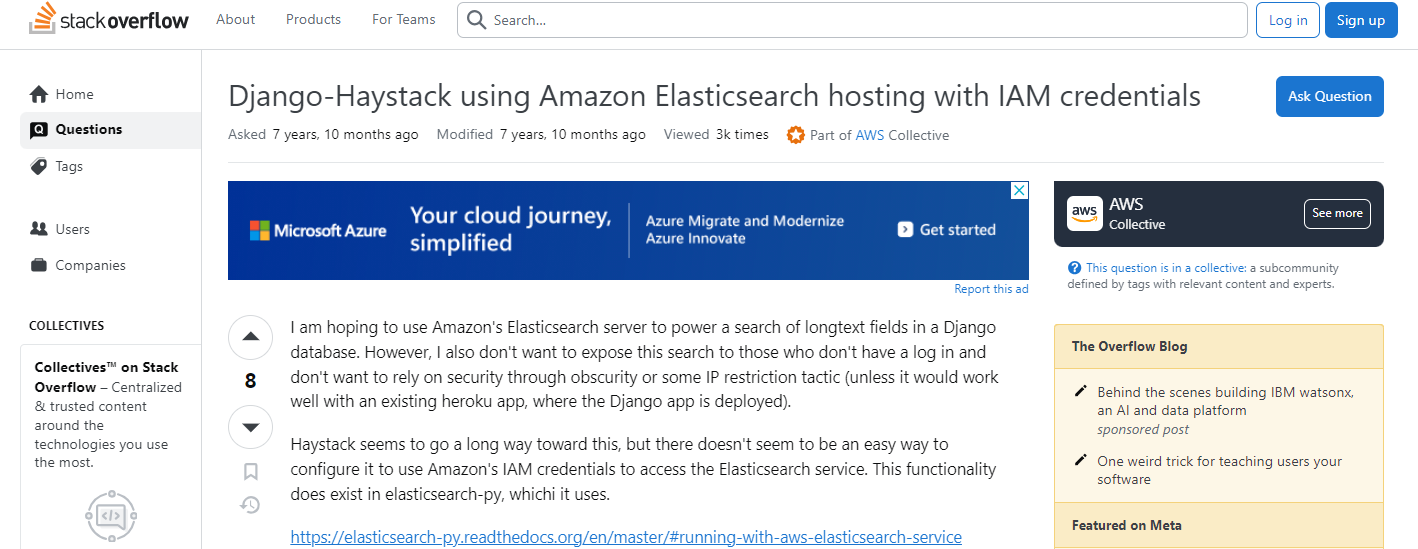

## Python Elasticsearch Client
https://elasticsearch-py.readthedocs.org/en/master/#running-with-aws-elasticsearch-service